In [1]:
# 20410097
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
from skimage.filters import apply_hysteresis_threshold
from skimage.color import rgb2gray
from skimage import exposure, filters
from skimage.morphology import binary_opening, binary_closing, square, white_tophat, disk, black_tophat
from skimage.restoration import denoise_bilateral
random.seed(0)

Cummulative Distribution Function (CDF)

In [2]:
def calculate_threshold_using_cdf(image, percentile=93):
    # Calculate the histogram of the image pixels.
    hist, bin_edges = np.histogram(image, bins=np.arange(257) / 256)

    # Compute the cumulative distribution function (CDF) from the histogram.
    cdf = hist.cumsum()

    # Normalize the CDF by dividing it by the maximum value of the CDF to convert into a scale of 0 to 1.
    cdf_normalized = cdf / cdf.max()

    # Determine the index of the bin edge where the normalized CDF reaches or exceeds the specified percentile.
    threshold_index = np.searchsorted(cdf_normalized, percentile / 100)

    # Retrieve the corresponding pixel value that serves as the threshold.
    threshold = bin_edges[threshold_index]
    return threshold

Read Image

In [3]:
# Define the paths for image folders, masks, and labels
mask_path = r'.\mask_images'
mask = PIL.Image.open(os.path.join(mask_path,'1.tif'))
mask = np.array(mask)
label_path = r'.\label_images'
label = PIL.Image.open(os.path.join(label_path,'1.tif'))
label = np.array(label)

img_path = r'.\retina_images_01_10'
img = cv2.imread(os.path.join(img_path,'1.tif'),cv2.IMREAD_COLOR)

Convert to green channel

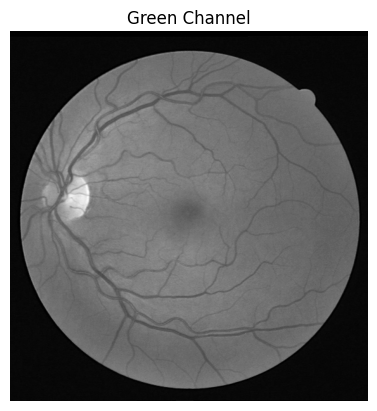

In [4]:
# Extract the green channel from the raw image
img_green = img[:, :, 1]

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()

# Display the image on the axes
ax.imshow(img_green, cmap='gray')

# Set the title of the plot
ax.set_title('Green Channel')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

Convert to grayscale using CLAHE

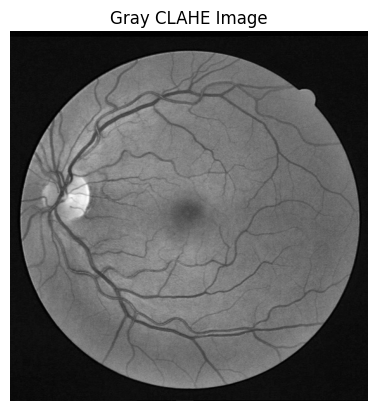

In [5]:
# Create a CLAHE object with limit to prevent noise enhancement
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))

# Apply CLAHE to the grayscale image
img_gray_clahe = clahe.apply(img_green)

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()
ax.imshow(img_gray_clahe, cmap='gray')

# Set the title of the plot
ax.set_title('Gray CLAHE Image')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

Gaussian blur

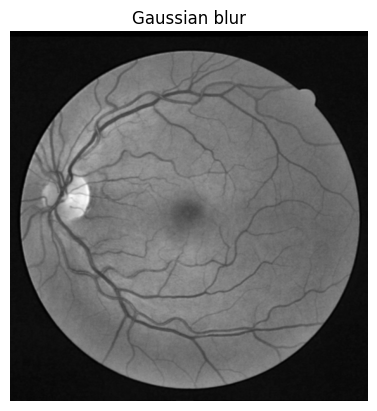

In [6]:
# Smooth the image using a Gaussian filter to reduce noise
img_smoothed = cv2.GaussianBlur(img_gray_clahe, (3, 3), 0.74)

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()
ax.imshow(img_smoothed, cmap='gray')

# Set the title of the plot
ax.set_title('Gaussian blur')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

Top-Hat Enhancement

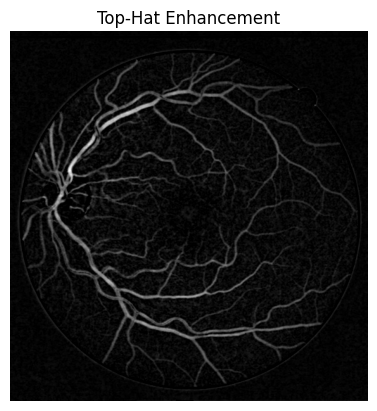

In [7]:
# Enhance the smoothed image using morphological top-hat operation with a disk of radius 6
selem = disk(6)  # Structuring element
img_tophat = black_tophat(img_smoothed, footprint=selem)

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()
ax.imshow(img_tophat, cmap='gray')

# Set the title of the plot
ax.set_title('Top-Hat Enhancement')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

Contrast Enhancement

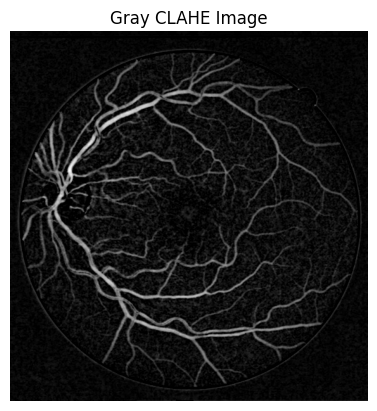

In [8]:
# Enhance the contrast of retina to better distinct the vessels from the background
img_tophat = img_tophat / img_tophat.max() if img_tophat.dtype == np.uint8 else img_tophat # Normalize to [0, 1]
img_contrast_enhanced_tophat = exposure.equalize_adapthist(img_tophat)

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()
ax.imshow(img_contrast_enhanced_tophat, cmap='gray')

# Set the title of the plot
ax.set_title('Gray CLAHE Image')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

Cummulative Distribution Function Threshold

(-0.5, 564.5, 583.5, -0.5)

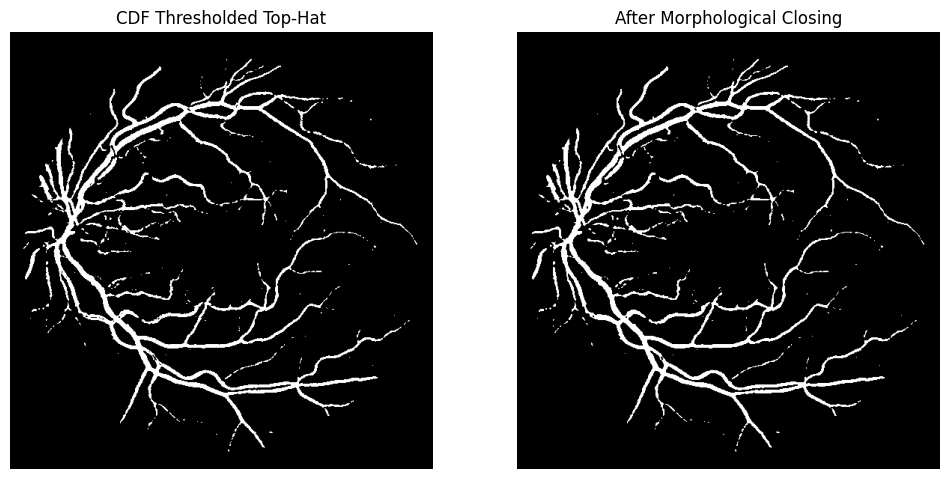

In [9]:
# Apply threshold
threshold_value_tophat = calculate_threshold_using_cdf(img_contrast_enhanced_tophat)
img_CDF_thresholded_tophat = img_contrast_enhanced_tophat > threshold_value_tophat  

# Apply binary closing
img_CDF_thresholded_tophat_closed = binary_closing(img_CDF_thresholded_tophat, footprint=square(2))

# Plotting the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_CDF_thresholded_tophat, cmap='gray')
ax[0].set_title('CDF Thresholded Top-Hat')
ax[0].axis('off')

ax[1].imshow(img_CDF_thresholded_tophat_closed, cmap='gray')
ax[1].set_title('After Morphological Closing')
ax[1].axis('off')

Hysteresis Threshold

(-0.5, 564.5, 583.5, -0.5)

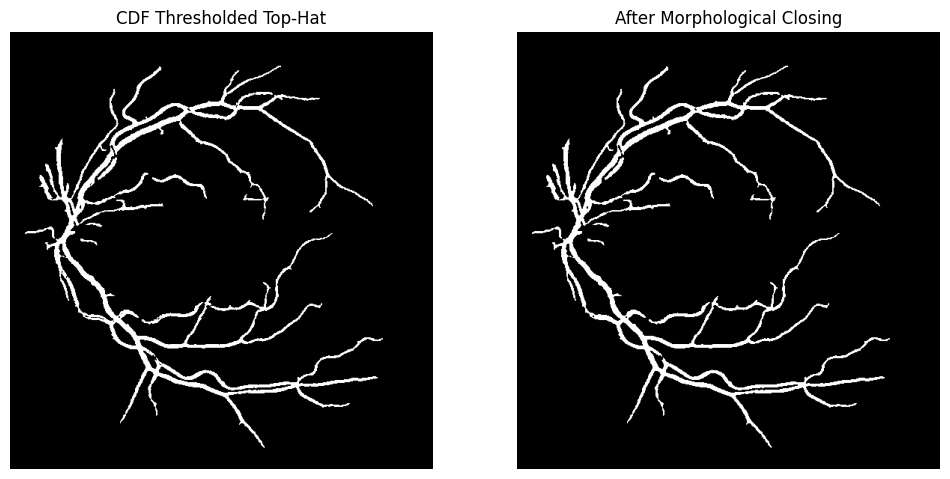

In [10]:
# Apply threshold
low_threshold, high_threshold = 0.172, 0.4  # lower threshold value, upper threshold value
img_hysteresis_thresholded_tophat = filters.apply_hysteresis_threshold(img_tophat, low_threshold, high_threshold)   # Convert to binary img based on hysteresis threshold

# Apply binary closing
img_hysteresis_thresholded_tophat_closed = binary_closing(img_hysteresis_thresholded_tophat, footprint=square(2))

# Plotting the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_hysteresis_thresholded_tophat, cmap='gray')
ax[0].set_title('CDF Thresholded Top-Hat')
ax[0].axis('off')

ax[1].imshow(img_hysteresis_thresholded_tophat_closed, cmap='gray')
ax[1].set_title('After Morphological Closing')
ax[1].axis('off')

Combine binary image for final output

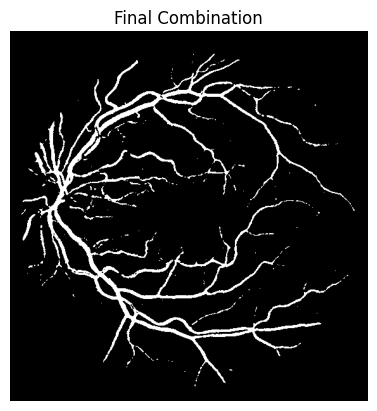

P:  0.6932884536923705
N:  0.985063985843613
T:  0.94681718714485


In [11]:
# COMBINE BOTH THRESHOLD
vessels_final = img_hysteresis_thresholded_tophat + img_CDF_thresholded_tophat

# Create a figure and axis object using plt.subplots
fig, ax = plt.subplots()
ax.imshow(vessels_final, cmap='gray')

# Set the title of the plot
ax.set_title('Final Combination')

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()
TP = sum(sum((label==255) & (vessels_final==1) & (mask == 255)))
TN = sum(sum((label==0) & (vessels_final==0) & (mask == 255)))
FP = sum(sum((label==0) & (vessels_final==1) & (mask == 255)))
FN = sum(sum((label==255) & (vessels_final==0) & (mask == 255)))

P = TP/(TP+FN)
N = TN/(TN+FP)
T = (TP+TN)/(TP+FN+TN+FP)

print('P: ', P)
print('N: ', N)
print('T: ', T)

In [12]:
# Define the paths for image folders, masks, and labels
img_path_1 = r'.\retina_images_01_10'
img_path_2 = r'.\retina_images_11_20'
mask_path = r'.\mask_images'

# Initialize cumulative metrics for averaging performance across images
P_total, N_total, T_total = 0., 0., 0.

for i in range(1, 21):
    # Load the color image from corresponding path depending on the image index
    if i < 11:
        img = cv2.imread(os.path.join(img_path_1,str(i)+'.tif'),cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(os.path.join(img_path_2,str(i)+'.tif'),cv2.IMREAD_COLOR)
        
    # Load associated mask and label images for use in segmentation validation
    mask = np.array(PIL.Image.open(os.path.join(mask_path, f"{i}.tif")))
    label = np.array(PIL.Image.open(os.path.join(label_path,str(i)+'.tif')))

    # --------------------------------------------- Preprocessing ----------------------------------------------
    # Extract the green channel from the raw image
    img_green = img[:, :, 1]

    # Create a CLAHE object with limit to prevent noise enhancement
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8))

    # Apply CLAHE to the grayscale image
    img_gray_clahe = clahe.apply(img_green)

    # -------------------------------------------- Gaussian Smooth ---------------------------------------------
    # Smooth the image using a Gaussian filter to reduce noise
    img_smoothed = cv2.GaussianBlur(img_gray_clahe, (3, 3), 0.74)


    # ------------------------------------------------ TOPHAT --------------------------------------------------
    # Enhance the smoothed image using morphological top-hat operation with a disk of radius 6
    selem = disk(6)  # Structuring element
    img_tophat = black_tophat(img_smoothed, footprint=selem)

    # --------------------------------------- Apply contrast enhancement ----------------------------------------
    img_tophat = img_tophat / img_tophat.max() if img_tophat.dtype == np.uint8 else img_tophat                          # Normalize to [0, 1]
    img_contrast_enhanced_tophat = exposure.equalize_adapthist(img_tophat)


    # ------------------------------- CUMULATIVE DISTRIBUTION FUNCTION THRESHOLD --------------------------------
    threshold_value_tophat = calculate_threshold_using_cdf(img_contrast_enhanced_tophat)
    img_CDF_thresholded_tophat = img_contrast_enhanced_tophat > threshold_value_tophat                                  # Convert to binary img based on CDF threshold


    # ------------------------------------------ HYSTERESIS THRESHOLD -------------------------------------------
    low_threshold, high_threshold = 0.172, 0.4  # lower threshold value, upper threshold value
    img_hysteresis_thresholded_tophat = filters.apply_hysteresis_threshold(img_tophat, low_threshold, high_threshold)   # Convert to binary img based on hysteresis threshold

    # MORPHOLOGICAL CLOSING for closing holes and gaps
    img_CDF_thresholded_tophat = binary_closing(img_CDF_thresholded_tophat, footprint=square(2))
    img_hysteresis_thresholded_tophat = binary_closing(img_hysteresis_thresholded_tophat, footprint=square(2))

    # COMBINE BOTH THRESHOLD
    vessels_final = img_hysteresis_thresholded_tophat + img_CDF_thresholded_tophat

    # Calculate true positives, true negatives, false positives, and false negatives
    TP = np.sum((label == 255) & (vessels_final == 1) & (mask == 255))
    TN = np.sum((label == 0) & (vessels_final == 0) & (mask == 255))
    FP = np.sum((label == 0) & (vessels_final == 1) & (mask == 255))
    FN = np.sum((label == 255) & (vessels_final == 0) & (mask == 255))

    P_total += TP/(TP+FN)
    N_total += TN/(TN+FP)
    T_total += (TP+TN)/(TP+FN+TN+FP)

print('P Average: ', P_total/20)
print('N Average: ', N_total/20)
print('T Average: ', T_total/20)
    


P Average:  0.6912015290181948
N Average:  0.9813120297955594
T Average:  0.9440318770997076
